# Methodology repeatability

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [329]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from paper import styles
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from scipy.interpolate import interp1d
from scipy.stats import norm

In [3]:
ship_name = "optiwise"

In [4]:
model = catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia']()

[04/10/25 10:25:11] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=264504;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=747713;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=556586;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=749965;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'optiwise.models_VCT_MDL'                        ]8;id=211689;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=673931;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

## Repeated tests

In [122]:
meta_datas = catalog.load(f"{ship_name}.test_meta_data")

meta_datas = meta_datas.groupby('test_type').get_group('zigzag')
mask = meta_datas['ship_speed'] > 0.9
meta_datas = meta_datas.loc[mask].copy()

#mask = meta_datas['angle'] == -20
angle = -20
mask = meta_datas['angle'] == angle

meta_datas = meta_datas.loc[mask].copy()


meta_datas[['ship_speed','angle']]

[04/10/25 11:12:08] INFO     Loading data from 'optiwise.test_meta_data' (CSVDataSet)...        ]8;id=55790;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=631717;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

,ship_speed,angle
23594,0.935783,-20.0
23595,0.935783,-20.0
23682,0.935783,-20.0


In [161]:
dataframes = {}

for i,(id,row) in enumerate(meta_datas.sort_index(ascending=False).iterrows()):
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    
    #dataframes[f"Experiment {id}"] = model.forces_from_motions(df_EKF_smooth)
    letter = chr(65+i)
    #dataframes[f"zigzag{abs(angle)}/{abs(angle)} {letter}"] = model.forces_from_motions(df_EKF_smooth)
    dataframes[f"{letter}"] = model.forces_from_motions(df_EKF_smooth)

dataframes = pd.Series(dataframes)

[04/10/25 11:18:02] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=383604;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=479620;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

[04/10/25 11:18:03] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=241861;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=459542;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=802189;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=806889;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

[04/10/25 11:18:07] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=139369;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=362847;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

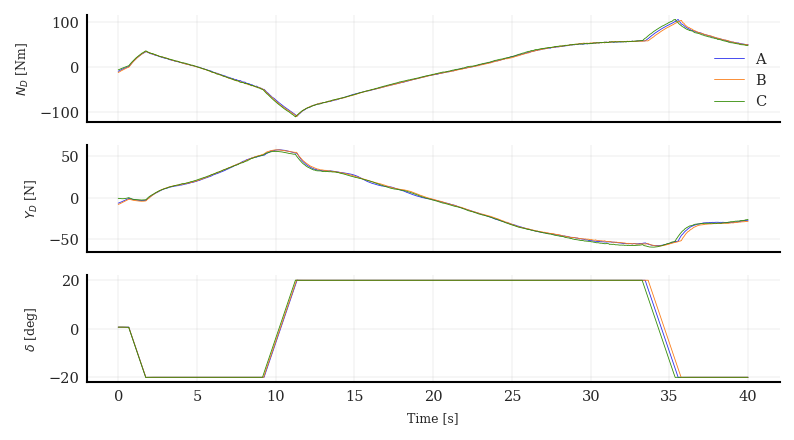

In [162]:
fig = plot(dataframes, keys=['Y_D','N_D','delta'],ncols=1, units=units, time_window=[0,40], symbols=symbols);
paper.save_fig(fig, "zigzag20.svg")

[04/14/25 09:07:57] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=393535;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=909850;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

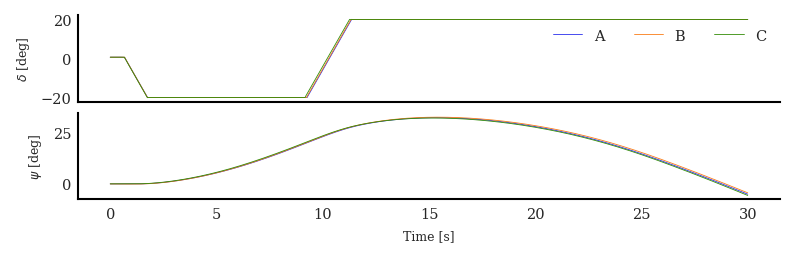

In [276]:
fig = plot(dataframes, keys=['psi','delta'],ncols=1, units=units, time_window=[0,30], symbols=symbols);
fig.set_size_inches(paper.figure_width, paper.figure_height/2)
ax = fig.axes[0]
ax.legend(ncols=3)

for ax in fig.axes:
    #ax.get_yaxis().set_label_coords(-0.07,0.5)
    ax.grid(False)

paper.save_fig(fig, "zigzag.svg")

In [303]:
id0 = dataframes.keys()[0]
df0 = dataframes[id0]
dataframes_sync = {}
for id, df in dataframes.items():

    df_ = pd.DataFrame(index=df0.index)
    
    for key,value in df.items():

        f = interp1d(x=df.index, y=df[key], bounds_error=False, assume_sorted=True)
        df_[key] = f(df0.index)
        
    df_.dropna(inplace=True)

    dataframes_sync[id] = df_

t_max = np.min([df_.index[-1] for id, df_ in dataframes_sync.items()])

for id, df_ in dataframes_sync.items():
    dataframes_sync[id] = df_.loc[0:t_max]

for id, df_ in dataframes_sync.items():
    dataframes_sync[id] = df_.loc[5:30]

[04/14/25 11:05:11] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=243673;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=626751;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

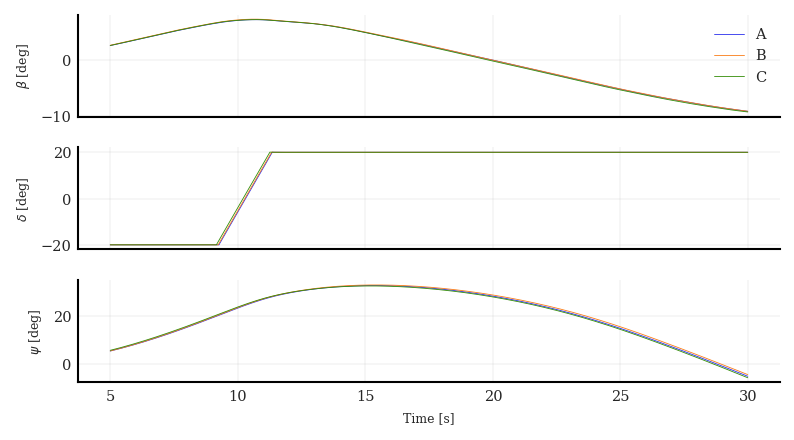

In [304]:
fig = plot(dataframes_sync, keys=['psi','beta','delta'],ncols=1, units=units, time_window=[0,40], symbols=symbols);

In [305]:
dataframes_diff = {id:df_-dataframes_sync[id0] for id,df_ in dataframes_sync.items()}

In [306]:
symbols['Y_D'] = 'Y_D'
symbols['N_D'] = 'N_D'

In [307]:
symbols_diff = {key:value+fr"^{{(\bullet)}}-{value}^A" for key,value in symbols.items()}

In [308]:
symbols_diff


{
    'beta': '\\beta^{(\\bullet)}-\\beta^A',
    'psi': '\\psi^{(\\bullet)}-\\psi^A',
    'delta': '\\delta^{(\\bullet)}-\\delta^A',
    'alpha': '\\alpha^{(\\bullet)}-\\alpha^A',
    'alpha_R': '\\alpha_R^{(\\bullet)}-\\alpha_R^A',
    'alpha_port': '\\alpha_{port}^{(\\bullet)}-\\alpha_{port}^A',
    'alpha_stbd': '\\alpha_{stbd}^{(\\bullet)}-\\alpha_{stbd}^A',
    'Y_D': 'Y_D^{(\\bullet)}-Y_D^A',
    'N_D': 'N_D^{(\\bullet)}-N_D^A'
}

[04/14/25 11:05:15] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=686279;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=718537;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

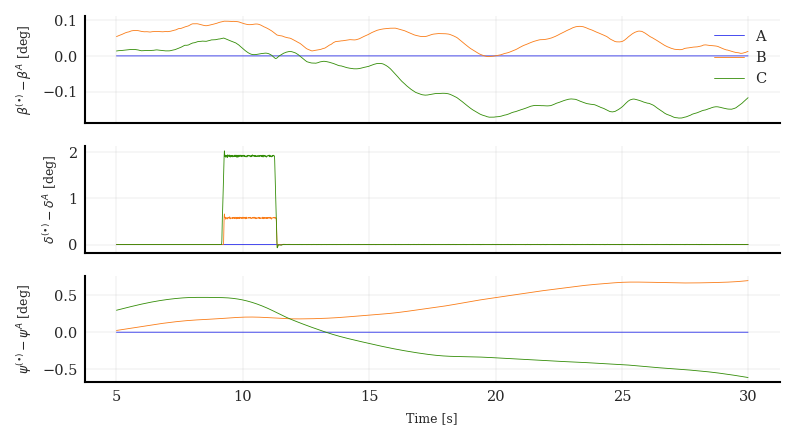

In [309]:
fig = plot(dataframes_diff, keys=['psi','beta','delta'],ncols=1, units=units, time_window=[0,40], symbols=symbols_diff);
paper.save_fig(fig, "diff1.svg")

[04/14/25 11:05:17] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=139071;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=445609;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

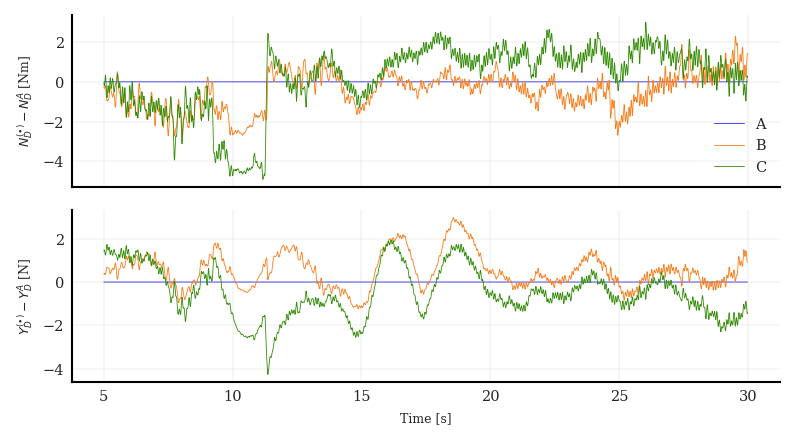

In [310]:
fig = plot(dataframes_diff, keys=['Y_D','N_D',],ncols=1, units=units, time_window=[5,40], symbols=symbols_diff);
paper.save_fig(fig, "diff2.svg")

[04/14/25 11:05:18] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=853400;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=922508;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

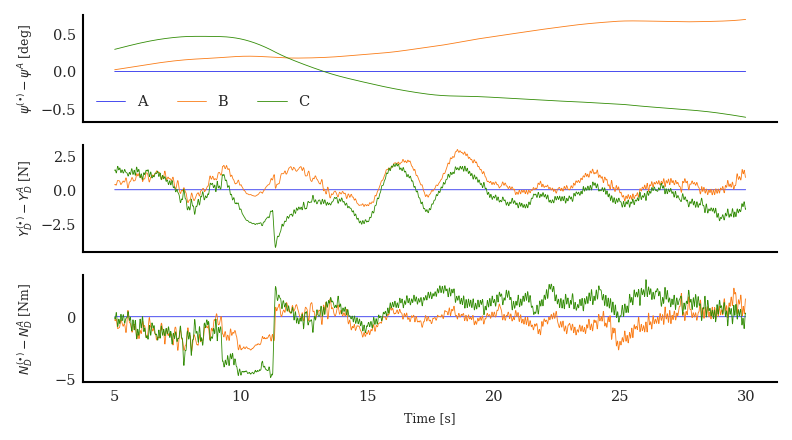

In [311]:
fig = plot(dataframes_diff, keys=['psi','Y_D','N_D',],ncols=1, units=units, time_window=[5,30], symbols=symbols_diff, sort_keys=False);
ax = fig.axes[0]
ax.legend(ncols=3)

for ax in fig.axes:
    ax.get_yaxis().set_label_coords(-0.07,0.5)
    ax.grid(False)

paper.save_fig(fig, "diff_all.svg")

In [324]:
df_std = pd.DataFrame({id: df_.loc[5:30].std() for id, df_ in dataframes_diff.items()})
df_mean = pd.DataFrame({id: df_.loc[5:30].mean() for id, df_ in dataframes_diff.items()})

In [325]:
stds = df_std[df_std.columns[1:]].mean(axis=1)
stds


x0        0.017458
y0        0.024217
psi       0.005032
u         0.001704
v         0.000863
r         0.000663
delta     0.005975
thrust    0.302911
beta      0.000880
u1d       0.003374
v1d       0.000431
r1d       0.000436
U         0.001699
fx        3.745094
fy        0.973530
mz        1.308882
X_D       3.745094
Y_D       0.973530
N_D       1.308882
dtype: float64

In [326]:
means = df_mean[df_std.columns[1:]].mean(axis=1)
means


x0        0.020322
y0        0.040385
psi       0.002227
u         0.001985
v         0.000099
r        -0.000082
delta     0.001815
thrust    0.096957
beta     -0.000201
u1d      -0.000071
v1d       0.000060
r1d      -0.000058
U         0.002043
fx       -0.021755
fy        0.006485
mz       -0.132481
X_D      -0.021755
Y_D       0.006485
N_D      -0.132481
dtype: float64

In [314]:
df_max = pd.DataFrame({id: df_.loc[5:30].abs().max() for id, df_ in dataframes_diff.items()})
maxs = df_max[df_std.columns[1:]].max(axis=1)
maxs


x0         0.069585
y0         0.114433
psi        0.012130
u          0.007111
v          0.002591
r          0.003097
delta      0.035319
thrust     1.277022
beta       0.003037
u1d        0.008970
v1d        0.001566
r1d        0.001800
U          0.007058
fx        10.270416
fy         4.257968
mz         4.908838
X_D       10.270416
Y_D        4.257968
N_D        4.908838
dtype: float64

In [315]:
np.rad2deg(maxs['psi'])

0.6949897690038139

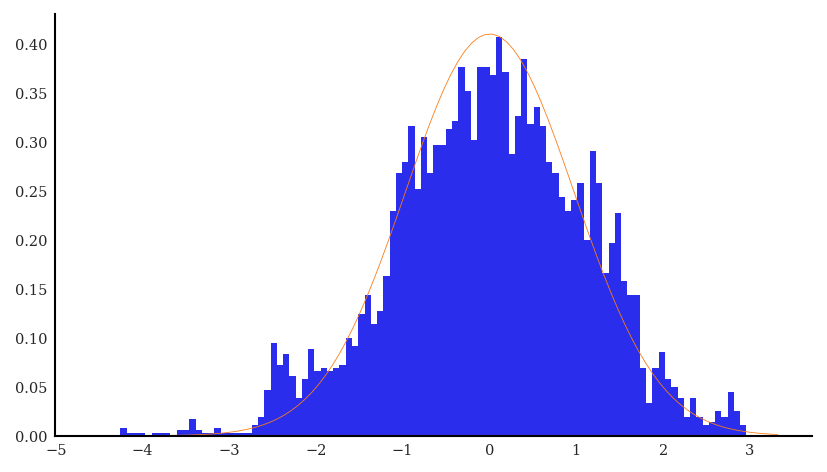

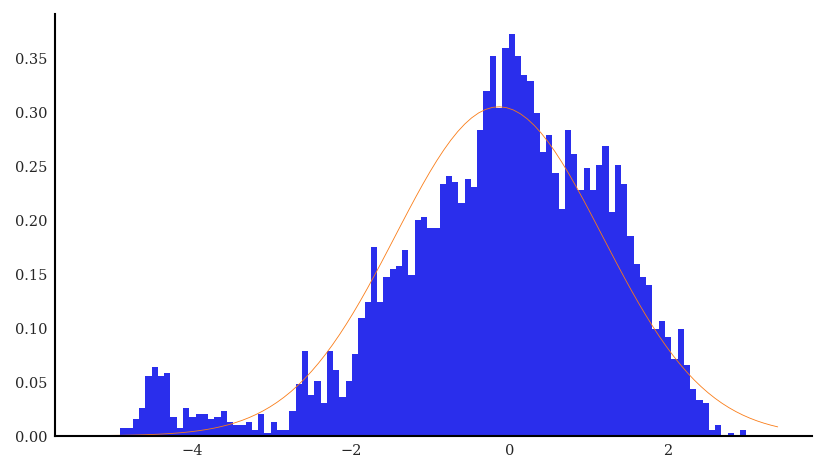

In [334]:
df_diff = pd.concat((dataframes_diff[dataframes.keys()[1]],dataframes_diff[dataframes.keys()[2]]),axis=0)

for key in ['Y_D','N_D']:

    fig,ax=plt.subplots()
    
    ax.hist(x=df_diff[key], density=True, bins=100);
    
    xlim = ax.get_xlim()
    rv = norm(loc=means[key], scale=stds[key])
    x = np.linspace(xlim[0],xlim[1],100)
    ax.plot(x,rv.pdf(x))


<Axes: >

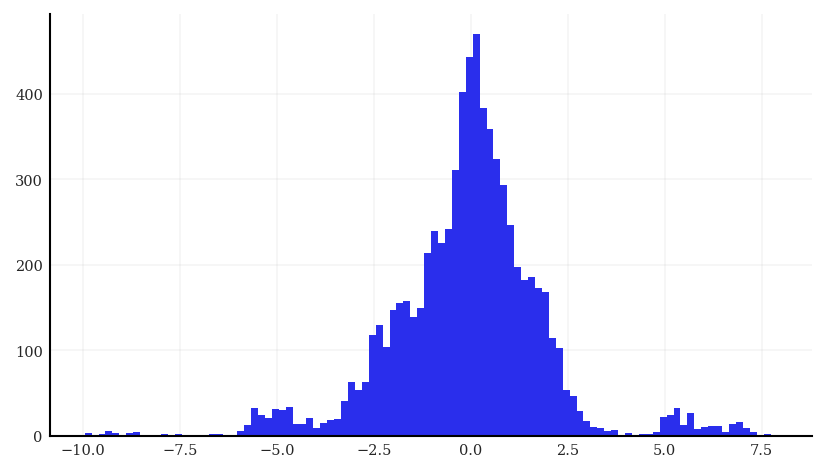

In [239]:
df_diff = dataframes_diff[dataframes.keys()[1]]
df_diff['N_D'].hist(bins=100)

<Axes: >

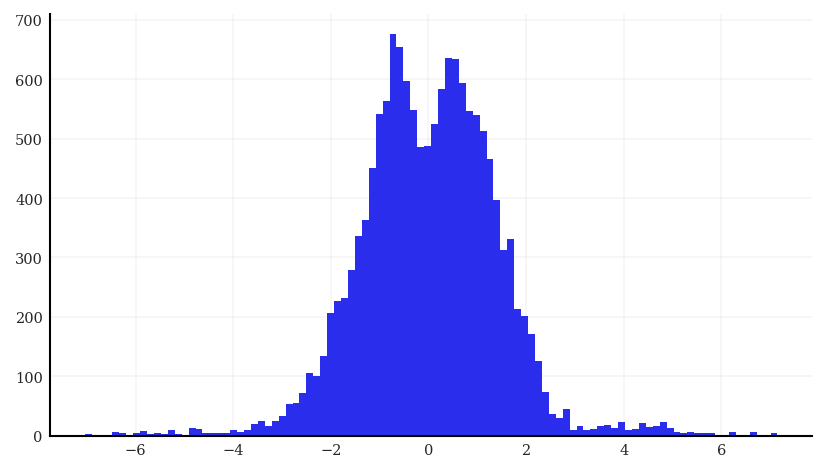

In [240]:
df_diff = pd.concat((dataframes_diff[dataframes.keys()[1]],dataframes_diff[dataframes.keys()[2]]), axis=0)
df_diff['Y_D'].hist(bins=100)

<Axes: >

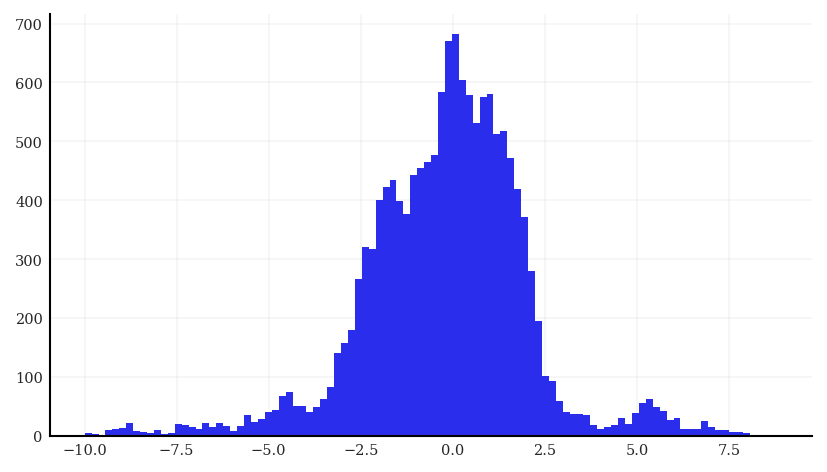

In [241]:
df_diff = pd.concat((dataframes_diff[dataframes.keys()[1]],dataframes_diff[dataframes.keys()[2]]), axis=0)
df_diff['N_D'].hist(bins=100)

<Axes: >

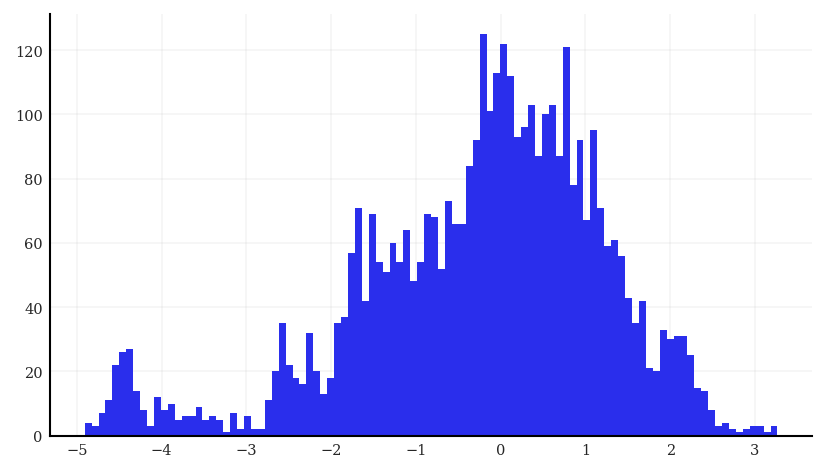

In [242]:
df_diff = pd.concat((dataframes_diff[dataframes.keys()[1]].loc[0:20],dataframes_diff[dataframes.keys()[2]].loc[0:20]), axis=0)
df_diff['N_D'].hist(bins=100)

<Axes: >

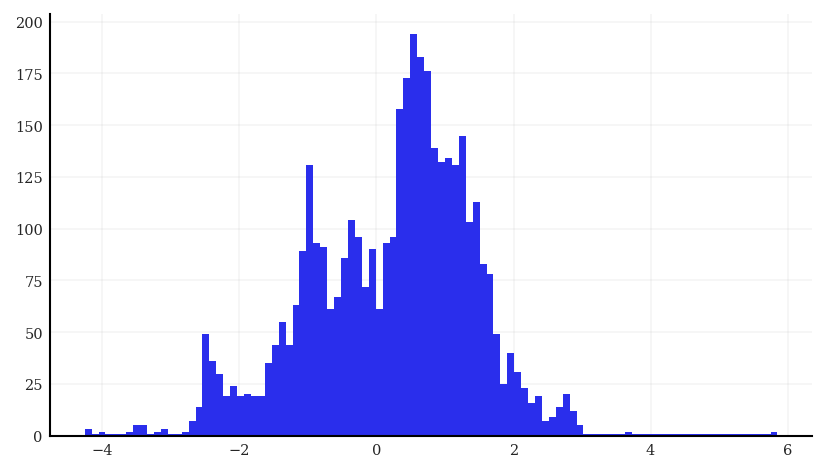

In [243]:
df_diff = pd.concat((dataframes_diff[dataframes.keys()[1]].loc[0:20],dataframes_diff[dataframes.keys()[2]].loc[0:20]), axis=0)
df_diff['Y_D'].hist(bins=100)

<Axes: xlabel='time'>

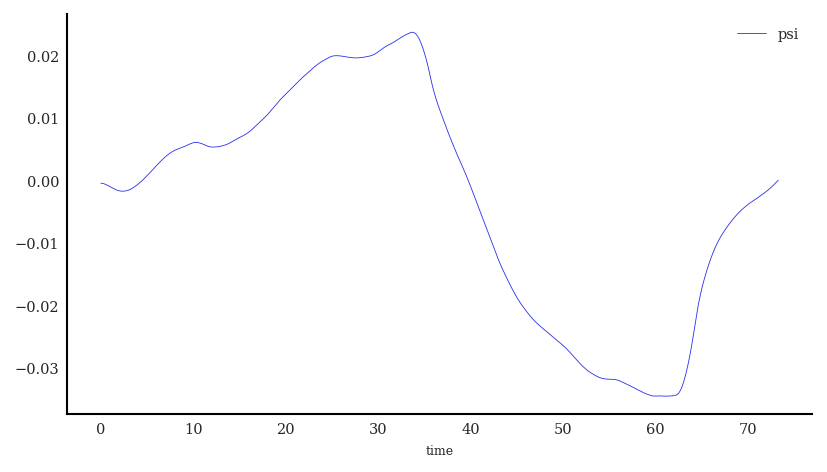

In [287]:
(dataframes_diff['B']/dataframes_sync['A'].abs().max()).plot(y='psi')

<Axes: xlabel='time'>

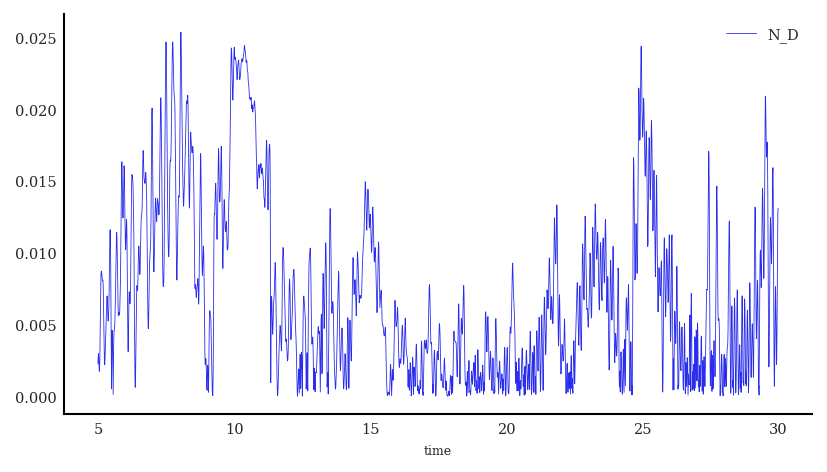

In [294]:
(dataframes_diff['B'].abs()/dataframes_sync['A'].abs().max()).loc[5:30].plot(y='N_D')

<Axes: xlabel='time'>

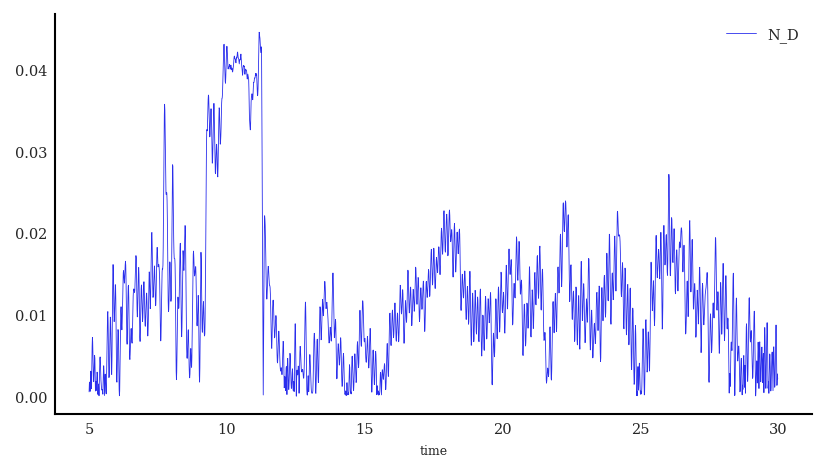

In [295]:
(dataframes_diff['C'].abs()/dataframes_sync['A'].abs().max()).loc[5:30].plot(y='N_D')

<Axes: xlabel='time'>

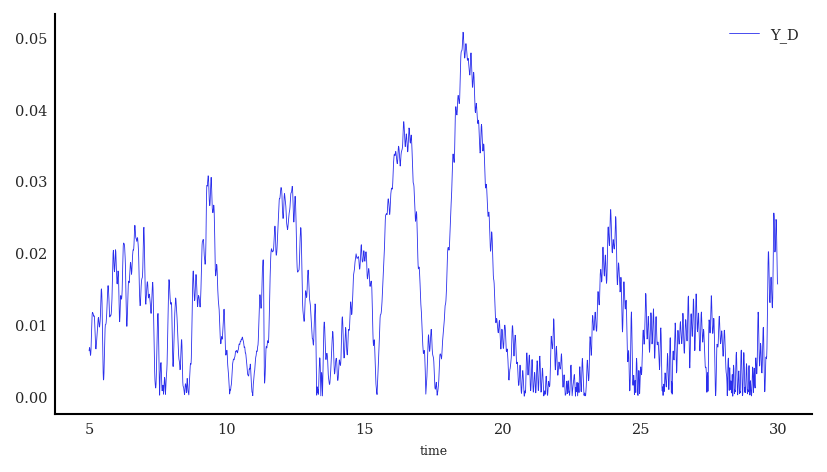

In [292]:
(dataframes_diff['B'].abs()/dataframes_sync['A'].abs().max()).loc[5:30].plot(y='Y_D')

<Axes: xlabel='time'>

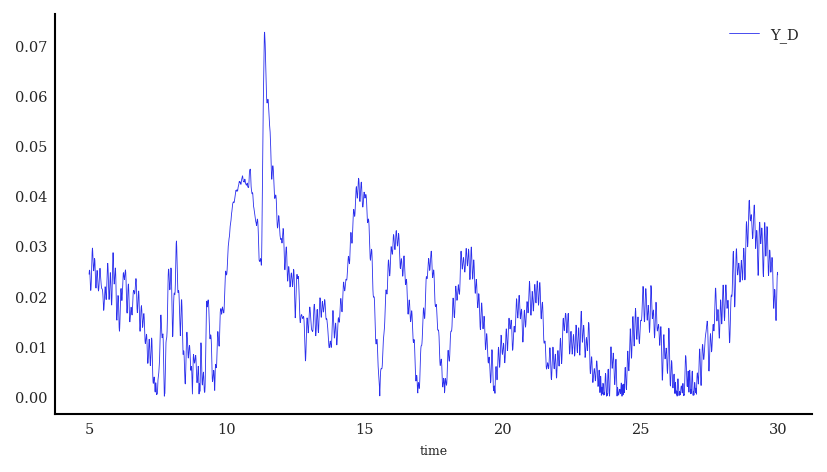

In [293]:
(dataframes_diff['C'].abs()/dataframes_sync['A'].abs().max()).loc[5:30].plot(y='Y_D')

In [297]:
maxs/dataframes_sync['A'].loc[5:30].abs().max()


x0        0.002861
y0        0.016625
psi       0.021358
u         0.007660
v         0.021172
r         0.041768
delta     0.100737
thrust    0.079731
beta      0.018950
u1d       0.423941
v1d       0.094107
r1d       0.076954
U         0.007594
fx        0.820514
fy        0.073231
mz        0.044542
X_D       0.820514
Y_D       0.073231
N_D       0.044542
dtype: float64

In [299]:
stds/dataframes_sync['A'].loc[5:30].abs().max()


x0        0.000718
y0        0.003518
psi       0.008861
u         0.001836
v         0.007052
r         0.008943
delta     0.017041
thrust    0.018912
beta      0.005491
u1d       0.159473
v1d       0.025900
r1d       0.018625
U         0.001828
fx        0.299199
fy        0.016743
mz        0.011876
X_D       0.299199
Y_D       0.016743
N_D       0.011876
dtype: float64

In [301]:
3*stds/dataframes_sync['A'].loc[5:30].abs().max()


x0        0.002154
y0        0.010555
psi       0.026583
u         0.005507
v         0.021155
r         0.026830
delta     0.051122
thrust    0.056737
beta      0.016472
u1d       0.478419
v1d       0.077700
r1d       0.055875
U         0.005485
fx        0.897598
fy        0.050230
mz        0.035629
X_D       0.897598
Y_D       0.050230
N_D       0.035629
dtype: float64